# WSmart+ Route Prototype

In [ ]:
from notebook_setup import setup_google_colab, setup_home_directory

NOTEBOOK_NAME = "prototype"
home_dir = setup_home_directory(NOTEBOOK_NAME)
IN_COLAB, gdrive, gfiles = setup_google_colab(NOTEBOOK_NAME)

In [ ]:
if IN_COLAB:
    %pip install fast-tsp
    %pip install matplotlib
    %pip install tqdm
    %pip install pandas
    %pip install torch
    %pip install cuda-cudart
    %pip install cudatoolkit
    %pip install jupyter
    %pip install networkx
    %pip install numpy
    %pip install torch_geometric

In [ ]:
import json
import os
import sys
import time
import traceback

import IPython.display as disp
import numpy as np
import pandas as pd
import torch

%matplotlib inline
import matplotlib.pyplot as plt
from logic.src.pipeline.simulator.bins import Bins
from logic.src.pipeline.simulator.day import get_daily_results, set_daily_waste
from logic.src.pipeline.simulator.loader import (
    load_depot,
    load_indices,
    load_simulator_data,
)
from logic.src.pipeline.simulator.network import apply_edges, compute_distance_matrix
from logic.src.pipeline.simulator.processor import (
    process_data,
    process_model_data,
    sort_dataframe,
)
from logic.src.pipeline.simulator.wsmart_bin_analysis import OldGridBase
from logic.src.utils.log_utils import log_to_json, read_json
from logic.src.utils.plot_utils import plot_linechart
from tqdm import tqdm

from logic.src.utils.definitions import DAY_METRICS, SIM_METRICS, TQDM_COLOURS
from logic.src.utils.functions import load_model

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

FIXED_POINT_NOTATION = True  # False to use scientific notation instead
FLOAT_DIGITS_PRECISION = 15
np.set_printoptions(precision=FLOAT_DIGITS_PRECISION)
np.set_printoptions(suppress=FIXED_POINT_NOTATION)

pd.options.mode.chained_assignment = None  # default='warn'
if IN_COLAB:
    gdrive.mount("/content/drive")

# Required to use matplotlib in Windows without breaking the Kernel
if os.name == "nt":
    os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

Ndays = 31
n_bins = 20
area = "Rio Maior"
waste_type = "plastic"
area = re.sub(r"[^a-zA-Z]", "", area.lower())

data_dir = os.path.join(home_dir, "data", "wsr_simulator")
output_dir = os.path.join(
    home_dir, "assets", "output", f"{Ndays}_days", f"{area}_{n_bins}"
)
try:
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)
except Exception:
    traceback.print_exc(file=sys.stdout)

In [ ]:
def read_output(json_path, policies):
    with open(json_path) as json_file:
        json_data = json.load(json_file)
    tmp = []
    for key, val in json_data.items():
        if key in policies:
            tmp.append(val)
    tmp = pd.DataFrame(tmp).values.transpose().tolist()
    return tmp


def get_results(dir_path, nbins_ls, policies, dist_name="gamma1"):
    log = []
    out_policies = [f"{pol}_{dist_name}" for pol in policies]
    for nbins in nbins_ls:
        path = os.path.join(dir_path, f"log_print{nbins}.json")
        tmp = read_output(path, out_policies)
        log.append(tmp)
    return np.array(log), out_policies


def generate_log_dict(policies, log, logm=None):
    if logm is None:
        logm = [None] * len(log)
    for pol, val, valm in zip(policies, log, logm):
        yield (pol, val if valm is None else valm)

In [ ]:
NC = n_bins + 1  # with depot
binsids = np.arange(0, NC - 1).tolist()

gamma_option = 0
data_distribution = "emp"  # "gamma"|"emp"
depot = load_depot(data_dir, area)
data, bins_coordinates = load_simulator_data(data_dir, n_bins, area, waste_type)
assert data.shape == bins_coordinates.shape

print(f"Area {area} ({bins_coordinates.shape[0]} full) for {n_bins} bins")
print(f"Lat: [{bins_coordinates['Lat'].min()}, {bins_coordinates['Lat'].max()}]")
print(f"Lng: [{bins_coordinates['Lng'].min()}, {bins_coordinates['Lng'].max()}]")
if area == "riomaior":
    grid = OldGridBase(data_dir, area)
else:
    grid = None

Area riomaior (173 full) for 20 bins
Lat: [39.25353454, 39.4429361111111]
Lng: [-8.984290944, -8.79266007]


In [ ]:
Nsamples = 10
start_id = 0
assert start_id < Nsamples

log_filepath = os.path.join(output_dir, f"log_mean_{Nsamples}N.json")
dist_name = f"gamma{gamma_option + 1}" if data_distribution == "gamma" else "emp"
daily_log_path = os.path.join(output_dir, f"daily_{dist_name}_{Nsamples}N.json")
if Nsamples > 1:
    logfull_filepath = os.path.join(output_dir, f"log_full_{Nsamples}N.json")

data_size = bins_coordinates.shape[0]
if data_size > n_bins:
    idx_filename = f"graphs_{n_bins}V_1N_{waste_type}.json"
    indices_ls = load_indices(idx_filename, Nsamples, n_bins, data_size)
else:
    indices_ls = [None] * Nsamples

daily_waste_path = os.path.join(
    data_dir,
    "daily_waste",
    "{}{}_{}_wsr{}_N{}_seed{}.pkl".format(
        area, n_bins, dist_name, Ndays, Nsamples, SEED
    ),
)
if not os.path.exists(daily_waste_path):
    load_waste = False
    daily_waste_path = None
    print(f"Specified daily waste fill file {daily_waste_path} does not exist")
else:
    load_waste = True

In [ ]:
outer_path = os.path.join(
    "assets", "model_weights", f"vrpp{n_bins}_riomaior_{waste_type}"
)
policies = ["am", "amgc", "transgcn"]
if dist_name != "emp":
    model_paths = ["{}/{}/{}".format(outer_path, dist_name, pol) for pol in policies]
else:
    model_paths = [
        f"{outer_path}/gamma1/{policies[0]}",
        f"{outer_path}/gamma1/{policies[1]}",
        f"{outer_path}/gamma1/{policies[2]}",
        f"{outer_path}/gamma2/{policies[0]}",
        f"{outer_path}/gamma2/{policies[1]}",
        f"{outer_path}/gamma2/{policies[2]}",
        f"{outer_path}/gamma3/{policies[0]}",
        f"{outer_path}/gamma3/{policies[1]}",
        f"{outer_path}/gamma3/{policies[2]}",
    ]
    policies = [
        "{}{}".format(pol, dist) for pol in policies for dist in ["g1", "g2", "g3"]
    ]

suffix = ""
policies = [
    "{}{}_{}".format(pol, f"_{suffix}" if suffix else "", dist_name) for pol in policies
]
model_paths = [
    "{}{}".format(model_path, f"_{suffix}" if suffix else "")
    for model_path in model_paths
]
# policies = policies[1::3]
# model_paths = model_paths[1::3]
# policies = policies[2:3]
# model_paths = model_paths[2:3]
policies

['am0g1_emp',
 'am0g2_emp',
 'am0g3_emp',
 'amgc0g1_emp',
 'amgc0g2_emp',
 'amgc0g3_emp',
 'transgcn0g1_emp',
 'transgcn0g2_emp',
 'transgcn0g3_emp']

In [ ]:
run_tsp = False
method = "mmn"
edge_thresh = 0.3
edge_method = "knn"
norm_method = "mmn"
decode_type = "greedy"
softmax_temperature = 1
device = torch.device(
    "cpu" if not torch.cuda.is_available() else f"cuda:{torch.cuda.device_count() - 1}"
)
print("Device set to", device)

Device set to cuda:1


In [ ]:
log = []
epoch = None
attention_dict = {model_name: [] for model_name in policies}
new_data, coordinates = process_data(
    data, bins_coordinates, depot, indices=indices_ls[0]
)
distance_matrix = compute_distance_matrix(coordinates, "og")
dist_matrix_edges, _, adj_matrix = apply_edges(
    distance_matrix, edge_thresh, edge_method
)
distancesC = np.round(dist_matrix_edges * 10).astype("int32")
distC_tensor = torch.from_numpy(distancesC).to(device)
for pol_id, (pol, m_path) in enumerate(zip(policies, model_paths)):
    model, configs = load_model(os.path.join(home_dir, m_path), epoch=epoch)
    print(f"{pol}")
    print(configs)
    model.to(device)
    model.eval()
    model.set_decode_type(decode_type, temp=softmax_temperature)
    model_data, graph, profit_vars = process_model_data(
        coordinates,
        distancesC,
        device,
        norm_method,
        configs,
        edge_thresh,
        edge_method,
        area,
        waste_type,
        adj_matrix,
    )
    for sample_id in range(start_id, Nsamples):
        overflows = 0
        bins = Bins(
            NC - 1, data_dir, data_distribution, grid, waste_file=daily_waste_path
        )
        bins.set_indices(indices_ls[sample_id])
        if data_distribution == "gamma":
            bins.setGammaDistribution(option=gamma_option)
        if daily_waste_path is not None:
            bins.set_sample_waste(sample_id)

        tours = []
        costs = []
        desc = f"{pol} #{sample_id}"
        daily_log = {key: [] for key in DAY_METRICS}
        colour = TQDM_COLOURS[pol_id % len(TQDM_COLOURS)]
        tic = time.perf_counter()
        for day in tqdm(range(1, Ndays + 1), desc=desc, colour=colour):
            tour = []
            new_overflows, fill, sum_lost = (
                bins.loadFilling(day - 1) if load_waste else bins.stochasticFilling()
            )
            daily_data = set_daily_waste(model_data, bins.c, device, fill)
            tour, cost, output_dict = model.compute_simulator_day(
                daily_data, graph, distC_tensor, profit_vars, run_tsp
            )

            overflows += new_overflows
            attention_dict[pol].append(output_dict)
            bins, dlog = get_daily_results(
                bins, cost, tour, day, new_overflows, sum_lost, coordinates
            )
            for key, val in dlog.items():
                daily_log[key].append(val)
        lg = [
            np.sum(bins.inoverflow),
            np.sum(bins.collected),
            np.sum(bins.ncollections),
            np.sum(bins.lost),
            bins.travel,
            np.nan_to_num(np.sum(bins.collected) / bins.travel, 0),
            np.sum(bins.inoverflow) - np.sum(bins.collected) + bins.travel,
            bins.ndays,
            time.process_time() - tic,
        ]
        print(lg)
        log.append(lg)
        if Nsamples > 1:
            log_to_json(logfull_filepath, SIM_METRICS, {pol: lg}, sample_id=sample_id)
            log_to_json(
                daily_log_path,
                DAY_METRICS,
                {f"{pol.rsplit('_', 1)[0]} #{sample_id}": daily_log.values()},
            )
        else:
            log_to_json(log_filepath, SIM_METRICS, {pol: lg})
            log_to_json(
                daily_log_path, DAY_METRICS, {pol.rsplit("_", 1)[0]: daily_log.values()}
            )

  [*] Loading model from /home/pkhunter/Repositories/wsr_tmp/assets/model_weights/riomaior_20/gamma1/am0/epoch-30.pt
am0g1_emp
{'problem': 'wcvrp', 'graph_size': 20, 'edge_threshold': 0.3, 'edge_method': 'knn', 'batch_size': 256, 'epoch_size': 128000, 'val_size': 0, 'val_dataset': None, 'eval_batch_size': 0, 'train_dataset': None, 'time_filename': 'data/datasets/wcvrp/wcvrp20_gamma1_real_seed42.pkl', 'eval_time_days': 1, 'train_time': True, 'area': 'riomaior', 'waste_type': 'plastic', 'focus_graph': 'graphs_20V_1N_PLASTIC.json', 'focus_size': 1, 'eval_focus_size': 0, 'distance_method': 'og', 'vertex_method': 'mmn', 'model': 'am', 'encoder': 'gat', 'embedding_dim': 128, 'hidden_dim': 512, 'n_encode_layers': 3, 'n_encode_sublayers': None, 'n_predict_layers': None, 'n_decode_layers': None, 'temporal_horizon': 3, 'tanh_clipping': 10.0, 'normalization': 'instance', 'learn_affine': True, 'track_stats': False, 'epsilon_alpha': 1e-05, 'momentum_beta': 0.1, 'lrnorm_k': None, 'gnorm_groups': 4, 

am0g1_emp #0: 100%|██████████| 31/31 [00:00<00:00, 80.24it/s]


[1.0, 5477.0, 620.0, 1.0, 7395.900000000001, 0.7405454373369028, 1919.9000000000005, 31, 0.3873511529964162]


am0g1_emp #1: 100%|██████████| 31/31 [00:00<00:00, 79.92it/s]


[0.0, 5554.0, 620.0, 0.0, 7453.4, 0.7451632811871093, 1899.3999999999996, 31, 0.38895848000538535]


am0g1_emp #2: 100%|██████████| 31/31 [00:00<00:00, 82.25it/s]


[0.0, 5161.0, 620.0, 0.0, 7331.799999999999, 0.7039199105267465, 2170.7999999999993, 31, 0.37807312900258694]


am0g1_emp #3: 100%|██████████| 31/31 [00:00<00:00, 82.70it/s]


[1.0, 5040.0, 620.0, 9.0, 7480.500000000002, 0.6737517545618606, 2441.500000000002, 31, 0.37603865000710357]


am0g1_emp #4: 100%|██████████| 31/31 [00:00<00:00, 82.49it/s]


[0.0, 5199.0, 620.0, 0.0, 7113.7999999999965, 0.7308330287610001, 1914.7999999999965, 31, 0.3770766329980688]


am0g1_emp #5: 100%|██████████| 31/31 [00:00<00:00, 83.00it/s]


[1.0, 5468.0, 620.0, 10.0, 7496.400000000001, 0.7294167867242942, 2029.4000000000005, 31, 0.37507094199827407]


am0g1_emp #6: 100%|██████████| 31/31 [00:00<00:00, 82.78it/s]


[1.0, 4988.0, 620.0, 6.0, 7339.700000000001, 0.6795918089295202, 2352.7000000000007, 31, 0.37609566100582015]


am0g1_emp #7: 100%|██████████| 31/31 [00:00<00:00, 82.73it/s]


[0.0, 5663.0, 620.0, 0.0, 7549.2, 0.7501457108037938, 1886.1999999999998, 31, 0.37598563500796445]


am0g1_emp #8: 100%|██████████| 31/31 [00:00<00:00, 82.65it/s]


[1.0, 5035.0, 620.0, 23.0, 7379.900000000001, 0.6822585671892573, 2345.9000000000005, 31, 0.3762276419874979]


am0g1_emp #9: 100%|██████████| 31/31 [00:00<00:00, 83.20it/s]


[1.0, 5243.0, 620.0, 10.0, 7408.2, 0.7077292729677924, 2166.2, 31, 0.37366506199759897]
  [*] Loading model from /home/pkhunter/Repositories/wsr_tmp/assets/model_weights/riomaior_20/gamma1/amgc0/epoch-30.pt
am0g2_emp
{'problem': 'wcvrp', 'graph_size': 20, 'edge_threshold': 0.3, 'edge_method': 'knn', 'batch_size': 256, 'epoch_size': 128000, 'val_size': 0, 'val_dataset': None, 'eval_batch_size': 0, 'train_dataset': None, 'time_filename': 'data/datasets/wcvrp/wcvrp20_gamma1_real_seed42.pkl', 'eval_time_days': 1, 'train_time': True, 'area': 'riomaior', 'waste_type': 'plastic', 'focus_graph': 'graphs_20V_1N_PLASTIC.json', 'focus_size': 1, 'eval_focus_size': 0, 'distance_method': 'og', 'vertex_method': 'mmn', 'model': 'am', 'encoder': 'gac', 'embedding_dim': 128, 'hidden_dim': 512, 'n_encode_layers': 3, 'n_encode_sublayers': None, 'n_predict_layers': None, 'n_decode_layers': None, 'temporal_horizon': 3, 'tanh_clipping': 10.0, 'normalization': 'instance', 'learn_affine': True, 'track_stats': 

am0g2_emp #0: 100%|██████████| 31/31 [00:00<00:00, 92.00it/s]


[45.0, 4736.0, 535.0, 274.0, 11375.799999999997, 0.4163223685367184, 6684.799999999997, 31, 0.3385491869994439]


am0g2_emp #1: 100%|██████████| 31/31 [00:00<00:00, 92.33it/s]


[43.0, 4850.0, 535.0, 388.0, 11383.499999999998, 0.4260552554135372, 6576.499999999998, 31, 0.33761973500077147]


am0g2_emp #2: 100%|██████████| 31/31 [00:00<00:00, 90.49it/s]


[30.0, 4454.0, 535.0, 327.0, 11369.5, 0.39174985707374993, 6945.5, 31, 0.3442319859896088]


am0g2_emp #3: 100%|██████████| 31/31 [00:00<00:00, 91.46it/s]


[22.0, 4579.0, 533.0, 157.0, 11374.400000000003, 0.40257068504712323, 6817.400000000003, 31, 0.3403798279905459]


am0g2_emp #4: 100%|██████████| 31/31 [00:00<00:00, 91.84it/s]


[31.0, 5006.0, 539.0, 234.0, 11415.1, 0.43854193130152164, 6440.1, 31, 0.338850687010563]


am0g2_emp #5: 100%|██████████| 31/31 [00:00<00:00, 87.71it/s]


[34.0, 4986.0, 541.0, 236.0, 11448.9, 0.4355003537457747, 6496.9, 31, 0.35497803700855]


am0g2_emp #6: 100%|██████████| 31/31 [00:00<00:00, 92.78it/s]


[38.0, 5158.0, 529.0, 325.0, 11266.999999999995, 0.4577971065944797, 6146.9999999999945, 31, 0.3356568869930925]


am0g2_emp #7: 100%|██████████| 31/31 [00:00<00:00, 92.91it/s]


[41.0, 4916.0, 532.0, 264.0, 11355.199999999999, 0.43292940679160213, 6480.199999999999, 31, 0.33473742500063963]


am0g2_emp #8: 100%|██████████| 31/31 [00:00<00:00, 92.98it/s]


[33.0, 5096.0, 530.0, 217.0, 11260.9, 0.45253931746130416, 6197.9, 31, 0.33456762399873696]


am0g2_emp #9: 100%|██████████| 31/31 [00:00<00:00, 90.43it/s]


[41.0, 4882.0, 537.0, 386.0, 11391.0, 0.4285839698007199, 6550.0, 31, 0.34406301700801123]
  [*] Loading model from /home/pkhunter/Repositories/wsr_tmp/assets/model_weights/riomaior_20/gamma1/transgcn0/epoch-30.pt
am0g3_emp
{'problem': 'wcvrp', 'graph_size': 20, 'edge_threshold': 0.3, 'edge_method': 'knn', 'batch_size': 256, 'epoch_size': 128000, 'val_size': 0, 'val_dataset': None, 'eval_batch_size': 0, 'train_dataset': None, 'time_filename': 'data/datasets/wcvrp/wcvrp20_gamma1_real_seed42.pkl', 'eval_time_days': 1, 'train_time': True, 'area': 'riomaior', 'waste_type': 'plastic', 'focus_graph': 'graphs_20V_1N_PLASTIC.json', 'focus_size': 1, 'eval_focus_size': 0, 'distance_method': 'og', 'vertex_method': 'mmn', 'model': 'am', 'encoder': 'tgc', 'embedding_dim': 128, 'hidden_dim': 512, 'n_encode_layers': 3, 'n_encode_sublayers': 1, 'n_predict_layers': None, 'n_decode_layers': None, 'temporal_horizon': 3, 'tanh_clipping': 10.0, 'normalization': 'instance', 'learn_affine': True, 'track_stat

am0g3_emp #0: 100%|██████████| 31/31 [00:00<00:00, 89.07it/s]


[20.0, 4914.0, 558.0, 195.0, 11760.7, 0.417832271888578, 6866.700000000001, 31, 0.3493252210028004]


am0g3_emp #1: 100%|██████████| 31/31 [00:00<00:00, 88.98it/s]


[30.0, 4991.0, 558.0, 227.0, 11831.599999999997, 0.4218364380134556, 6870.599999999997, 31, 0.34967845599749126]


am0g3_emp #2: 100%|██████████| 31/31 [00:00<00:00, 88.52it/s]


[40.0, 5176.0, 558.0, 387.0, 11833.0, 0.43742077241612437, 6697.0, 31, 0.3514735539938556]


am0g3_emp #3: 100%|██████████| 31/31 [00:00<00:00, 88.07it/s]


[35.0, 4977.0, 558.0, 276.0, 11812.499999999998, 0.4213333333333334, 6870.499999999998, 31, 0.35338227001193445]


am0g3_emp #4: 100%|██████████| 31/31 [00:00<00:00, 89.40it/s]


[39.0, 4785.0, 558.0, 295.0, 11829.2, 0.40450748994014807, 7083.200000000001, 31, 0.3480273000022862]


am0g3_emp #5: 100%|██████████| 31/31 [00:00<00:00, 90.08it/s]


[40.0, 4945.0, 558.0, 233.0, 11760.4, 0.4204788952756709, 6855.4, 31, 0.3453865390038118]


am0g3_emp #6: 100%|██████████| 31/31 [00:00<00:00, 85.36it/s]


[27.0, 4829.0, 558.0, 199.0, 11731.5, 0.4116268166901078, 6929.5, 31, 0.36445092599024065]


am0g3_emp #7: 100%|██████████| 31/31 [00:00<00:00, 89.18it/s]


[26.0, 5005.0, 558.0, 196.0, 11731.1, 0.42664370775119126, 6752.1, 31, 0.34875845900387503]


am0g3_emp #8: 100%|██████████| 31/31 [00:00<00:00, 90.06it/s]


[39.0, 4288.0, 558.0, 263.0, 11720.0, 0.3658703071672355, 7471.0, 31, 0.34546202000638004]


am0g3_emp #9: 100%|██████████| 31/31 [00:00<00:00, 87.38it/s]


[24.0, 4945.0, 557.0, 177.0, 11835.1, 0.41782494444491386, 6914.1, 31, 0.35605605199816637]
  [*] Loading model from /home/pkhunter/Repositories/wsr_tmp/assets/model_weights/riomaior_20/gamma2/am0/epoch-30.pt
amgc0g1_emp
{'problem': 'wcvrp', 'graph_size': 20, 'edge_threshold': 0.3, 'edge_method': 'knn', 'batch_size': 256, 'epoch_size': 128000, 'val_size': 0, 'val_dataset': None, 'eval_batch_size': 0, 'train_dataset': None, 'time_filename': 'data/datasets/wcvrp/wcvrp20_gamma2_real_seed42.pkl', 'eval_time_days': 1, 'train_time': True, 'area': 'riomaior', 'waste_type': 'plastic', 'focus_graph': 'graphs_20V_1N_PLASTIC.json', 'focus_size': 1, 'eval_focus_size': 0, 'distance_method': 'og', 'vertex_method': 'mmn', 'model': 'am', 'encoder': 'gat', 'embedding_dim': 128, 'hidden_dim': 512, 'n_encode_layers': 3, 'n_encode_sublayers': None, 'n_predict_layers': None, 'n_decode_layers': None, 'temporal_horizon': 3, 'tanh_clipping': 10.0, 'normalization': 'instance', 'learn_affine': True, 'track_stat

amgc0g1_emp #0: 100%|██████████| 31/31 [00:00<00:00, 83.24it/s]


[1.0, 5541.0, 620.0, 26.0, 8339.9, 0.6643964555929928, 2799.8999999999996, 31, 0.3735902180051198]


amgc0g1_emp #1: 100%|██████████| 31/31 [00:00<00:00, 82.41it/s]


[0.0, 5757.0, 620.0, 0.0, 8333.4, 0.6908344733242134, 2576.3999999999996, 31, 0.3774653589935042]


amgc0g1_emp #2: 100%|██████████| 31/31 [00:00<00:00, 81.17it/s]


[1.0, 5152.0, 620.0, 5.0, 8316.0, 0.6195286195286195, 3165.0, 31, 0.3833497029991122]


amgc0g1_emp #3: 100%|██████████| 31/31 [00:00<00:00, 83.63it/s]


[0.0, 4914.0, 620.0, 0.0, 8311.9, 0.5912005678605373, 3397.8999999999996, 31, 0.3721734970022226]


amgc0g1_emp #4: 100%|██████████| 31/31 [00:00<00:00, 82.68it/s]


[1.0, 5063.0, 620.0, 52.0, 8254.4, 0.6133698391161078, 3192.3999999999996, 31, 0.3761467449949123]


amgc0g1_emp #5: 100%|██████████| 31/31 [00:00<00:00, 82.79it/s]


[0.0, 5039.0, 620.0, 0.0, 8292.699999999999, 0.6076428666176277, 3253.699999999999, 31, 0.37549115301226266]


amgc0g1_emp #6: 100%|██████████| 31/31 [00:00<00:00, 82.71it/s]


[0.0, 5505.0, 620.0, 0.0, 8325.9, 0.6611897812849061, 2820.8999999999996, 31, 0.3758734739967622]


amgc0g1_emp #7: 100%|██████████| 31/31 [00:00<00:00, 82.91it/s]


[1.0, 4945.0, 620.0, 155.0, 8311.000000000002, 0.5949945854891107, 3367.000000000002, 31, 0.37526107499434147]


amgc0g1_emp #8: 100%|██████████| 31/31 [00:00<00:00, 83.22it/s]


[2.0, 5027.0, 620.0, 198.0, 8311.199999999999, 0.6048464722302436, 3286.199999999999, 31, 0.373508506003418]


amgc0g1_emp #9: 100%|██████████| 31/31 [00:00<00:00, 83.41it/s]


[0.0, 4982.0, 620.0, 0.0, 8258.499999999998, 0.6032572501059515, 3276.499999999998, 31, 0.37296402800711803]
  [*] Loading model from /home/pkhunter/Repositories/wsr_tmp/assets/model_weights/riomaior_20/gamma2/amgc0/epoch-30.pt
amgc0g2_emp
{'problem': 'wcvrp', 'graph_size': 20, 'edge_threshold': 0.3, 'edge_method': 'knn', 'batch_size': 256, 'epoch_size': 128000, 'val_size': 0, 'val_dataset': None, 'eval_batch_size': 0, 'train_dataset': None, 'time_filename': 'data/datasets/wcvrp/wcvrp20_gamma2_real_seed42.pkl', 'eval_time_days': 1, 'train_time': True, 'area': 'riomaior', 'waste_type': 'plastic', 'focus_graph': 'graphs_20V_1N_PLASTIC.json', 'focus_size': 1, 'eval_focus_size': 0, 'distance_method': 'og', 'vertex_method': 'mmn', 'model': 'am', 'encoder': 'gac', 'embedding_dim': 128, 'hidden_dim': 512, 'n_encode_layers': 3, 'n_encode_sublayers': None, 'n_predict_layers': None, 'n_decode_layers': None, 'temporal_horizon': 3, 'tanh_clipping': 10.0, 'normalization': 'instance', 'learn_affine'

amgc0g2_emp #0: 100%|██████████| 31/31 [00:00<00:00, 88.81it/s]


[17.0, 5128.0, 558.0, 200.0, 9585.1, 0.5349970266350899, 4474.1, 31, 0.35013217700179666]


amgc0g2_emp #1: 100%|██████████| 31/31 [00:00<00:00, 89.34it/s]


[43.0, 5161.0, 558.0, 363.0, 9405.000000000002, 0.5487506645401381, 4287.000000000002, 31, 0.3484132809971925]


amgc0g2_emp #2: 100%|██████████| 31/31 [00:00<00:00, 90.05it/s]


[40.0, 5131.0, 558.0, 374.0, 9940.900000000001, 0.516150449154503, 4849.9000000000015, 31, 0.3456341270066332]


amgc0g2_emp #3: 100%|██████████| 31/31 [00:00<00:00, 89.52it/s]


[27.0, 4216.0, 558.0, 268.0, 9258.600000000002, 0.45536042166202223, 5069.600000000002, 31, 0.34760501800337806]


amgc0g2_emp #4: 100%|██████████| 31/31 [00:00<00:00, 89.96it/s]


[36.0, 4665.0, 558.0, 249.0, 9603.100000000002, 0.48578063333715144, 4974.100000000002, 31, 0.3457168879976962]


amgc0g2_emp #5: 100%|██████████| 31/31 [00:00<00:00, 89.51it/s]


[41.0, 5243.0, 558.0, 215.0, 9598.500000000002, 0.5462311819555138, 4396.500000000002, 31, 0.34774292800284456]


amgc0g2_emp #6: 100%|██████████| 31/31 [00:00<00:00, 89.26it/s]


[46.0, 4997.0, 558.0, 307.0, 9809.000000000002, 0.5094301152003261, 4858.000000000002, 31, 0.34860660100821406]


amgc0g2_emp #7: 100%|██████████| 31/31 [00:00<00:00, 89.72it/s]


[31.0, 4782.0, 558.0, 224.0, 9424.200000000003, 0.5074170751894058, 4673.200000000003, 31, 0.34663157000613865]


amgc0g2_emp #8: 100%|██████████| 31/31 [00:00<00:00, 89.67it/s]


[39.0, 4437.0, 558.0, 331.0, 9928.4, 0.4468998025865195, 5530.4, 31, 0.34679123500245623]


amgc0g2_emp #9: 100%|██████████| 31/31 [00:00<00:00, 88.95it/s]


[34.0, 4888.0, 558.0, 312.0, 9562.200000000003, 0.5111794356947145, 4708.200000000003, 31, 0.34982065700751264]
  [*] Loading model from /home/pkhunter/Repositories/wsr_tmp/assets/model_weights/riomaior_20/gamma2/transgcn0/epoch-30.pt
amgc0g3_emp
{'problem': 'wcvrp', 'graph_size': 20, 'edge_threshold': 0.3, 'edge_method': 'knn', 'batch_size': 256, 'epoch_size': 128000, 'val_size': 0, 'val_dataset': None, 'eval_batch_size': 0, 'train_dataset': None, 'time_filename': 'data/datasets/wcvrp/wcvrp20_gamma2_real_seed42.pkl', 'eval_time_days': 1, 'train_time': True, 'area': 'riomaior', 'waste_type': 'plastic', 'focus_graph': 'graphs_20V_1N_PLASTIC.json', 'focus_size': 1, 'eval_focus_size': 0, 'distance_method': 'og', 'vertex_method': 'mmn', 'model': 'am', 'encoder': 'tgc', 'embedding_dim': 128, 'hidden_dim': 512, 'n_encode_layers': 3, 'n_encode_sublayers': 1, 'n_predict_layers': None, 'n_decode_layers': None, 'temporal_horizon': 3, 'tanh_clipping': 10.0, 'normalization': 'instance', 'learn_aff

amgc0g3_emp #0: 100%|██████████| 31/31 [00:00<00:00, 81.14it/s]


[0.0, 5389.0, 620.0, 0.0, 11051.399999999998, 0.48763052644913774, 5662.399999999998, 31, 0.3832059650012525]


amgc0g3_emp #1: 100%|██████████| 31/31 [00:00<00:00, 83.24it/s]


[0.0, 5000.0, 620.0, 0.0, 11382.2, 0.43928238829048866, 6382.200000000001, 31, 0.3736188460025005]


amgc0g3_emp #2: 100%|██████████| 31/31 [00:00<00:00, 83.12it/s]


[0.0, 5355.0, 620.0, 0.0, 11268.800000000001, 0.4752058781769132, 5913.800000000001, 31, 0.3741562490031356]


amgc0g3_emp #3: 100%|██████████| 31/31 [00:00<00:00, 82.74it/s]


[1.0, 5256.0, 620.0, 6.0, 11420.300000000001, 0.46023309370156645, 6165.300000000001, 31, 0.3758519539987901]


amgc0g3_emp #4: 100%|██████████| 31/31 [00:00<00:00, 82.64it/s]


[0.0, 5322.0, 620.0, 0.0, 11730.600000000002, 0.45368523349189294, 6408.600000000002, 31, 0.3762356249935692]


amgc0g3_emp #5: 100%|██████████| 31/31 [00:00<00:00, 82.46it/s]


[0.0, 4778.0, 620.0, 0.0, 11445.300000000003, 0.41746393716197905, 6667.300000000003, 31, 0.3770772309944732]


amgc0g3_emp #6: 100%|██████████| 31/31 [00:00<00:00, 81.91it/s]


[1.0, 5247.0, 620.0, 51.0, 11534.2, 0.4549080126926878, 6288.200000000001, 31, 0.37970124000275973]


amgc0g3_emp #7: 100%|██████████| 31/31 [00:00<00:00, 82.92it/s]


[0.0, 5372.0, 620.0, 0.0, 11730.500000000002, 0.457951493968714, 6358.500000000002, 31, 0.3753859239950543]


amgc0g3_emp #8: 100%|██████████| 31/31 [00:00<00:00, 82.84it/s]


[2.0, 5125.0, 620.0, 50.0, 11574.1, 0.44279900813022177, 6451.1, 31, 0.37546136300079525]


amgc0g3_emp #9: 100%|██████████| 31/31 [00:00<00:00, 82.82it/s]


[1.0, 5065.0, 620.0, 16.0, 11344.899999999998, 0.4464561168454549, 6280.899999999998, 31, 0.3754051780124428]
  [*] Loading model from /home/pkhunter/Repositories/wsr_tmp/assets/model_weights/riomaior_20/gamma3/am0/epoch-30.pt
transgcn0g1_emp
{'problem': 'wcvrp', 'graph_size': 20, 'edge_threshold': 0.3, 'edge_method': 'knn', 'batch_size': 256, 'epoch_size': 128000, 'val_size': 0, 'val_dataset': None, 'eval_batch_size': 0, 'train_dataset': None, 'time_filename': 'data/datasets/wcvrp/wcvrp20_gamma3_real_seed42.pkl', 'eval_time_days': 1, 'train_time': True, 'area': 'riomaior', 'waste_type': 'plastic', 'focus_graph': 'graphs_20V_1N_PLASTIC.json', 'focus_size': 1, 'eval_focus_size': 0, 'distance_method': 'og', 'vertex_method': 'mmn', 'model': 'am', 'encoder': 'gat', 'embedding_dim': 128, 'hidden_dim': 512, 'n_encode_layers': 3, 'n_encode_sublayers': None, 'n_predict_layers': None, 'n_decode_layers': None, 'temporal_horizon': 3, 'tanh_clipping': 10.0, 'normalization': 'instance', 'learn_affi

transgcn0g1_emp #0: 100%|██████████| 31/31 [00:00<00:00, 95.01it/s]


[54.0, 4323.0, 517.0, 491.0, 6565.799999999998, 0.6584117700813307, 2296.7999999999984, 31, 0.3274217750004027]


transgcn0g1_emp #1: 100%|██████████| 31/31 [00:00<00:00, 92.24it/s]


[64.0, 4545.0, 505.0, 324.0, 6481.0999999999985, 0.701269846168089, 2000.0999999999985, 31, 0.33724836600595154]


transgcn0g1_emp #2: 100%|██████████| 31/31 [00:00<00:00, 96.68it/s]


[40.0, 4557.0, 505.0, 248.0, 6479.799999999999, 0.7032624463718017, 1962.7999999999993, 31, 0.32209367500036024]


transgcn0g1_emp #3: 100%|██████████| 31/31 [00:00<00:00, 95.88it/s]


[69.0, 5042.0, 504.0, 533.0, 6480.099999999999, 0.778074412431907, 1507.0999999999995, 31, 0.3252127369923983]


transgcn0g1_emp #4: 100%|██████████| 31/31 [00:00<00:00, 92.86it/s]


[34.0, 4703.0, 517.0, 230.0, 6593.5999999999985, 0.713267410822616, 1924.5999999999985, 31, 0.33524165299604647]


transgcn0g1_emp #5: 100%|██████████| 31/31 [00:00<00:00, 96.17it/s]


[50.0, 4376.0, 506.0, 434.0, 6504.1, 0.6728063836656878, 2178.1000000000004, 31, 0.32367189800424967]


transgcn0g1_emp #6: 100%|██████████| 31/31 [00:00<00:00, 95.80it/s]


[56.0, 4537.0, 504.0, 416.0, 6478.700000000002, 0.7002948122308486, 1997.7000000000016, 31, 0.3249680180015275]


transgcn0g1_emp #7: 100%|██████████| 31/31 [00:00<00:00, 96.83it/s]


[51.0, 4238.0, 504.0, 580.0, 6472.800000000001, 0.6547398343838832, 2285.800000000001, 31, 0.32144028499897104]


transgcn0g1_emp #8: 100%|██████████| 31/31 [00:00<00:00, 94.46it/s]


[38.0, 4752.0, 505.0, 298.0, 6496.699999999999, 0.7314482737389753, 1782.699999999999, 31, 0.32968372901086695]


transgcn0g1_emp #9: 100%|██████████| 31/31 [00:00<00:00, 95.39it/s]


[43.0, 4623.0, 508.0, 297.0, 6521.499999999999, 0.7088859924863913, 1941.499999999999, 31, 0.3266266930004349]
  [*] Loading model from /home/pkhunter/Repositories/wsr_tmp/assets/model_weights/riomaior_20/gamma3/amgc0/epoch-30.pt
transgcn0g2_emp
{'problem': 'wcvrp', 'graph_size': 20, 'edge_threshold': 0.3, 'edge_method': 'knn', 'batch_size': 256, 'epoch_size': 128000, 'val_size': 0, 'val_dataset': None, 'eval_batch_size': 0, 'train_dataset': None, 'time_filename': 'data/datasets/wcvrp/wcvrp20_gamma3_real_seed42.pkl', 'eval_time_days': 1, 'train_time': True, 'area': 'riomaior', 'waste_type': 'plastic', 'focus_graph': 'graphs_20V_1N_PLASTIC.json', 'focus_size': 1, 'eval_focus_size': 0, 'distance_method': 'og', 'vertex_method': 'mmn', 'model': 'am', 'encoder': 'gac', 'embedding_dim': 128, 'hidden_dim': 512, 'n_encode_layers': 3, 'n_encode_sublayers': None, 'n_predict_layers': None, 'n_decode_layers': None, 'temporal_horizon': 3, 'tanh_clipping': 10.0, 'normalization': 'instance', 'learn_a

transgcn0g2_emp #0: 100%|██████████| 31/31 [00:00<00:00, 88.40it/s]


[0.0, 5082.0, 562.0, 0.0, 12522.099999999997, 0.4058424705121347, 7440.099999999997, 31, 0.35170776399900205]


transgcn0g2_emp #1: 100%|██████████| 31/31 [00:00<00:00, 86.78it/s]


[1.0, 5457.0, 564.0, 0.0, 12343.099999999997, 0.44210935664460316, 6887.099999999997, 31, 0.3586432989977766]


transgcn0g2_emp #2: 100%|██████████| 31/31 [00:00<00:00, 86.02it/s]


[0.0, 5560.0, 564.0, 0.0, 12231.6, 0.4545603191732888, 6671.6, 31, 0.361635228007799]


transgcn0g2_emp #3: 100%|██████████| 31/31 [00:00<00:00, 87.15it/s]


[2.0, 4895.0, 563.0, 37.0, 12085.699999999997, 0.40502411941385286, 7192.699999999997, 31, 0.3568916479998734]


transgcn0g2_emp #4: 100%|██████████| 31/31 [00:00<00:00, 86.09it/s]


[1.0, 4781.0, 565.0, 3.0, 11907.999999999996, 0.40149479341619093, 7127.999999999996, 31, 0.3611791110015474]


transgcn0g2_emp #5: 100%|██████████| 31/31 [00:00<00:00, 87.38it/s]


[5.0, 5003.0, 561.0, 15.0, 12404.299999999997, 0.40332787823577315, 7406.299999999997, 31, 0.3561768020008458]


transgcn0g2_emp #6: 100%|██████████| 31/31 [00:00<00:00, 86.45it/s]


[9.0, 5466.0, 563.0, 90.0, 12311.099999999997, 0.44398957038769904, 6854.099999999997, 31, 0.3598789990064688]


transgcn0g2_emp #7: 100%|██████████| 31/31 [00:00<00:00, 88.07it/s]


[2.0, 5104.0, 563.0, 52.0, 12628.699999999992, 0.40415878118887955, 7526.699999999992, 31, 0.35335384000791237]


transgcn0g2_emp #8: 100%|██████████| 31/31 [00:00<00:00, 88.77it/s]


[0.0, 5143.0, 564.0, 0.0, 12271.099999999999, 0.4191148307812666, 7128.0999999999985, 31, 0.3502946630032966]


transgcn0g2_emp #9: 100%|██████████| 31/31 [00:00<00:00, 87.88it/s]


[1.0, 4999.0, 563.0, 17.0, 12436.499999999996, 0.4019619667912999, 7438.499999999996, 31, 0.3537530309986323]
  [*] Loading model from /home/pkhunter/Repositories/wsr_tmp/assets/model_weights/riomaior_20/gamma3/transgcn0/epoch-30.pt
transgcn0g3_emp
{'problem': 'wcvrp', 'graph_size': 20, 'edge_threshold': 0.3, 'edge_method': 'knn', 'batch_size': 256, 'epoch_size': 128000, 'val_size': 0, 'val_dataset': None, 'eval_batch_size': 0, 'train_dataset': None, 'time_filename': 'data/datasets/wcvrp/wcvrp20_gamma3_real_seed42.pkl', 'eval_time_days': 1, 'train_time': True, 'area': 'riomaior', 'waste_type': 'plastic', 'focus_graph': 'graphs_20V_1N_PLASTIC.json', 'focus_size': 1, 'eval_focus_size': 0, 'distance_method': 'og', 'vertex_method': 'mmn', 'model': 'am', 'encoder': 'tgc', 'embedding_dim': 128, 'hidden_dim': 512, 'n_encode_layers': 3, 'n_encode_sublayers': 1, 'n_predict_layers': None, 'n_decode_layers': None, 'temporal_horizon': 3, 'tanh_clipping': 10.0, 'normalization': 'instance', 'learn_a

transgcn0g3_emp #0: 100%|██████████| 31/31 [00:00<00:00, 81.11it/s]


[1.0, 4874.0, 620.0, 0.0, 10411.199999999999, 0.46814968495466425, 5538.199999999999, 31, 0.3833461089961929]


transgcn0g3_emp #1: 100%|██████████| 31/31 [00:00<00:00, 81.23it/s]


[1.0, 4958.0, 620.0, 6.0, 9950.4, 0.49827142627432064, 4993.4, 31, 0.3827815250115236]


transgcn0g3_emp #2: 100%|██████████| 31/31 [00:00<00:00, 81.90it/s]


[1.0, 5561.0, 620.0, 3.0, 9994.599999999999, 0.5564004562463731, 4434.5999999999985, 31, 0.38020886800950393]


transgcn0g3_emp #3: 100%|██████████| 31/31 [00:00<00:00, 82.38it/s]


[0.0, 5205.0, 620.0, 0.0, 10313.399999999998, 0.5046832276455874, 5108.399999999998, 31, 0.3777834249922307]


transgcn0g3_emp #4: 100%|██████████| 31/31 [00:00<00:00, 82.57it/s]


[1.0, 5462.0, 620.0, 155.0, 9950.399999999998, 0.5489226563756232, 4489.399999999998, 31, 0.37671695899916813]


transgcn0g3_emp #5: 100%|██████████| 31/31 [00:00<00:00, 82.65it/s]


[1.0, 5267.0, 620.0, 32.0, 9878.499999999996, 0.5331781140861469, 4612.499999999996, 31, 0.37644960200123023]


transgcn0g3_emp #6: 100%|██████████| 31/31 [00:00<00:00, 82.75it/s]


[1.0, 5562.0, 620.0, 6.0, 9948.199999999999, 0.5590961178906737, 4387.199999999999, 31, 0.37582661799388006]


transgcn0g3_emp #7: 100%|██████████| 31/31 [00:00<00:00, 82.27it/s]


[1.0, 5163.0, 620.0, 16.0, 9963.3, 0.5182018006082323, 4801.299999999999, 31, 0.3779693149990635]


transgcn0g3_emp #8: 100%|██████████| 31/31 [00:00<00:00, 81.76it/s]


[2.0, 4965.0, 620.0, 20.0, 10045.600000000002, 0.49424623715855687, 5082.600000000002, 31, 0.38066414500644896]


transgcn0g3_emp #9: 100%|██████████| 31/31 [00:00<00:00, 80.94it/s]


[1.0, 5318.0, 620.0, 14.0, 10176.599999999999, 0.5225713892655701, 4859.5999999999985, 31, 0.38424491600017063]


In [ ]:
log_full = [log[id * Nsamples : (id + 1) * Nsamples] for id in range(len(policies))]
lgf_tmp = np.array(log_full)
lgf_tmp.shape

(9, 10, 9)

In [ ]:
import statistics

if Nsamples > 1:
    log_mean = []
    log_std = []
    for pol_log in log_full:
        log_mean.append([*map(statistics.mean, zip(*pol_log))])
        log_std.append([*map(statistics.stdev, zip(*pol_log))])

    for lg, pol in zip(log_mean, policies):
        print(f'"{pol}":', end=" ")
        print(json.dumps(dict(zip(SIM_METRICS, lg)), indent=True))

    print("Standard deviation")
    for lg, pol in zip(log_std, policies):
        print(f'"{pol}":', end=" ")
        print(json.dumps(dict(zip(SIM_METRICS, lg)), indent=True))
else:
    for lg, pol in zip(log, policies):
        print(f'"{pol}":', end=" ")
        print(json.dumps(dict(zip(SIM_METRICS, lg)), indent=True))

"am0g1_emp": {
 "overflows": 0.6,
 "kg": 5282.8,
 "ncol": 620.0,
 "kg_lost": 5.9,
 "km": 7394.88,
 "kg/km": 0.7143355558988277,
 "cost": 2112.68,
 "days": 31,
 "time": 0.37845429870067165
}
"am0g2_emp": {
 "overflows": 35.8,
 "kg": 4866.3,
 "ncol": 534.6,
 "kg_lost": 280.8,
 "km": 11364.13,
 "kg/km": 0.4282590251766531,
 "cost": 6533.629999999999,
 "days": 31,
 "time": 0.34036344129999635
}
"am0g3_emp": {
 "overflows": 32.0,
 "kg": 4885.5,
 "ncol": 557.9,
 "kg_lost": 244.8,
 "km": 11784.51,
 "kg/km": 0.4145374976920759,
 "cost": 6931.009999999999,
 "days": 31,
 "time": 0.3512000797010842
}
"amgc0g1_emp": {
 "overflows": 0.6,
 "kg": 5192.5,
 "ncol": 620.0,
 "kg_lost": 43.6,
 "km": 8305.49,
 "kg/km": 0.625126091115031,
 "cost": 3113.5899999999997,
 "days": 31,
 "time": 0.37558237580087733
}
"amgc0g2_emp": {
 "overflows": 35.4,
 "kg": 4864.8,
 "ncol": 558.0,
 "kg_lost": 284.3,
 "km": 9611.500000000002,
 "kg/km": 0.5062196805955385,
 "cost": 4782.100000000001,
 "days": 31,
 "time": 0.34770

In [ ]:
dit = dict(generate_log_dict(policies, log, log_mean))
logfile_path = os.path.join(output_dir, f"log_mean_{Nsamples}N.json")
log_to_json(logfile_path, SIM_METRICS, dit)
if Nsamples > 1:
    std_dit = dict(generate_log_dict(policies, log_std))
    logstdfile_path = os.path.join(output_dir, f"log_std_{Nsamples}N.json")
    log_to_json(logstdfile_path, SIM_METRICS, std_dit)

### Results for proto models
"am_over0.5_gamma1": {\
"overflows": 22.1,\
"kg": 465198.18665885524,\
"ncol": 18200.0,\
"kg_lost": 230.1851273107029,\
"km": 78903.31,\
"days": 364,\
"kg/km": 5.895804264360934,\
"time": 13.283670564600106\
},

"am_over0.5_length1.5_gamma1": {\
"overflows": 387.2,\
"kg": 455924.49305236764,\
"ncol": 14382.9,\
"kg_lost": 9215.87569096616,\
"km": 67401.29,\
"days": 364,\
"kg/km": 6.764338907767892,\
"time": 10.417988436200176\
},

"am_length2_gamma1": {\
"overflows": 722.3,\
"kg": 440140.7233276183,\
"ncol": 10713.7,\
"kg_lost": 24744.932055460748,\
"km": 54148.22999999999,\
"days": 364,\
"kg/km": 8.12849314128045,\
"time": 8.283329737599342\
},

"am_real_no_lost_length2_gamma1": {\
"overflows": 22.7,\
"kg": 465166.0392137409,\
"ncol": 17878.7,\
"kg_lost": 231.6156268808765,\
"km": 62195.66000000002,\
"days": 364,\
"kg/km": 7.479076031625092,\
"time": 12.70874313090062\
},

"am_real_no_lost_length4_gamma1": {\
 "overflows": 1873.4,\
 "kg": 416840.9052535482,\
 "ncol": 14352.5,\
 "kg_lost": 47892.06883840881,\
 "km": 60746.21000000001,\
 "days": 364,\
 "kg/km": 6.862020972846248,\
 "time": 10.550674468099896\
},

"am_real_no_lost_length3_gamma1": {\
 "overflows": 7576.2,\
 "kg": 264476.65057200246,\
 "ncol": 10556.0,\
 "kg_lost": 198851.72121416347,\
 "km": 35620.2400000001,\
 "days": 364,\
 "kg/km": 7.424901187650792,\
 "time": 7.887508904200149\
},

"am_real_length2_gamma1": {\
 "overflows": 28.0,\
 "kg": 465137.1293650984,\
 "ncol": 17874.4,\
 "kg_lost": 248.95711259985663,\
 "km": 61062.710000000014,\
 "days": 364,\
 "kg/km": 7.617367273453805,\
 "time": 8.719766925300004\
},

"am_over0.5_length2_gamma1": {\
 "overflows": 22.1,\
 "kg": 465198.18665885524,\
 "ncol": 18200.0,\
 "kg_lost": 230.1851273107029,\
 "km": 62961.07999999997,\
 "days": 364,\
 "kg/km": 7.388661656894296,\
 "time": 12.4732736037\
}

"am_over0.1_length2_gamma1": {\
 "overflows": 22.1,\
 "kg": 465198.18665885524,\
 "ncol": 18200.0,\
 "kg_lost": 230.1851273107029,\
 "km": 66817.96999999999,\
 "days": 364,\
 "kg/km": 6.962170903410573,\
 "time": 8.56753927839991\
}

In [ ]:
logfile_path = os.path.join(output_dir, f"log_print{n_bins}.json")
if len(policies) > 0:
    dit = {}
    for pol, val in zip(policies, log):
        dit[pol] = val.tolist()

    log_to_json(logfile_path, SIM_METRICS, dit, sort_log=False)

In [ ]:
disp_dists = ["gamma1", "gamma2", "gamma3", "emp"]
disp_policies = [
    "am",
    "amgc",
    "transgcn",
    "policy_last_minute50",
    "policy_last_minute_and_path50",
    "policy_regular3",
    "gurobi0.84",
]
out_log = read_json(logfile_path)
if False:
    disp_dict = {pol: {} for pol in disp_policies}
    for disp_dist in disp_dists:
        for key, val_dict in out_log.items():
            policy_strip = key.rsplit("_", 1)[0]
            if disp_dist in key and policy_strip in disp_policies:
                new_vdict = {}
                for v_k, v_v in val_dict.items():
                    new_vdict[(disp_dist, v_k)] = v_v

                disp_dict[policy_strip].update(new_vdict)

    display_policies = disp_dict.keys()
    out_df_trans = pd.DataFrame.from_dict(disp_dict, orient="index").round(decimals=4)
else:
    disp_dict = {}
    for disp_dist in disp_dists:
        for key, val in out_log.items():
            policy_strip = key.rsplit("_", 1)[0]
            if disp_dist in key and policy_strip in disp_policies:
                disp_dict[(disp_dist, policy_strip)] = val

    display_policies = disp_dict.keys()
    out_df = pd.DataFrame.from_dict(disp_dict, orient="index").round(decimals=4)

In [ ]:
full_index = pd.MultiIndex.from_product(
    [disp_dists, disp_policies], names=["Distribution", "Policy"]
)
out_df = out_df.reindex(full_index)
metrics = ["overflows", "kg", "ncol", "kg_lost", "km", "days", "kg/km", "time (s)"]
html_table = ['<table border="1">']
html_table.append(
    "<tr><th>distribution</th><th>policy</th>"
    + "".join(f"<th>{metric}</th>" for metric in metrics)
    + "</tr>"
)

# Group by Distribution level and build rows
for dist in disp_dists:
    dist_rows = out_df.index.get_level_values("Distribution") == dist
    dist_df = out_df[dist_rows]
    num_policies = len(disp_policies) + 1
    html_table.append(
        f'<tr><th rowspan="{num_policies}" style="vertical-align: middle; text-align: center;">{dist}</th></tr>'
    )
    for policy in disp_policies:
        row = (
            dist_df.loc[dist_df.index.get_level_values("Policy") == policy].iloc[0]
            if not dist_df.empty and policy in dist_df.index.get_level_values("Policy")
            else pd.Series()
        )
        row_data = row.values if not row.empty else [""] * len(metrics)
        cells = "".join(
            f"<td>{val}</td>" if pd.notna(val) else "<td></td>" for val in row_data
        )
        html_table.append(f"<tr><th>{policy}</th>{cells}</tr>")

html_table.append("</table>")
css = """
<style>
  th, td {
    border: 1px solid black;
    padding: 8px;
    text-align: center;
  }
  th[rowspan] {
    vertical-align: middle !important;
    text-align: center !important;
  }
  th:not([rowspan]) {
    text-align: center !important;
  }
</style>
"""
html_with_style = css + "\n".join(html_table)
disp.display(disp.HTML(html_with_style))

In [ ]:
metric_tosort = "overflows"
display(sort_dataframe(out_df, metric_tosort, ascending_order=True))

In [ ]:
metric_tosort = "kg/km"
display(sort_dataframe(out_df, metric_tosort, ascending_order=False))

In [ ]:
sing_disp_dist = "emp"
display_dists = ["gamma1", "gamma2", "gamma3", "emp"]
N_bins = [20, 50, 120]
Ndays = 31
display_policies = ["am", "amgc", "transgcn", "policy_last_minute_and_path50"]
disp_path = f"/home/pkhunter/Repositories/wsr_tmp/assets/output/{Ndays}_days/proto"
log_display, out_policies = get_results(
    disp_path, N_bins, display_policies, sing_disp_dist
)
log_display.shape

NameError: name 'get_results' is not defined

In [ ]:
# log_display = np.moveaxis(log_display, [0, 1, 2], [2, 0, 1])
# log_display2 = np.swapaxes(log_display, 0, 2)
# log_display = np.array([list(d.values()) for d in disp_dict.values()])
log_display2 = np.moveaxis(log_display, [0, 1, 2], [0, 2, 1])
log_display2.shape

In [ ]:
"""desc_suffix = f"{N_bins} bins ({sing_disp_dist})"
scale = "linear"
markers = ['P', 's', '^', '8'] #, '*']
linestyles = ['dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5))] #, 'solid']
plot_func = lambda x_val, l1, l2, l3, l4, line, mark: plt.plot(x_val, [(l1[-1]/60)/Ndays, (l2[-1]/60)/Ndays, (l3[-1]/60)/Ndays, (l4[-1]/60)/Ndays], linestyle=line, marker=mark)
output_path = os.path.join(output_dir, f"{scale}_comp{N_bins}_{sing_disp_dist}.png") if scale != "linear" \
    else os.path.join(output_dir, f"comp{N_bins}_{sing_disp_dist}.png")
pds = plot_linechart(output_path, log_display2, plot_func, display_policies, 'n_bins', 'runtime', f"Comparison: {desc_suffix}",
                    fsave=False, x_values=N_bins, scale=scale, linestyles=linestyles, markers=markers, annotate=False, pareto_front=False)"""

In [ ]:
log = get_results(output_log, [1], tmp_policies)
log = np.moveaxis(log, [0, 1, 2], [2, 0, 1])
log2 = np.swapaxes(log, 0, 2)

In [ ]:
pds_ls = []
name = "model_compare"
for disp_dist in display_dists:
    log_display, out_policies = get_results(
        disp_path, N_bins, display_policies, disp_dist
    )
    log_display2 = np.moveaxis(log_display, [0, 1, 2], [0, 2, 1])
    desc_suffix = f"Model compare: {N_bins} bins ({disp_dist})"
    scale = "linear"
    output_path = (
        os.path.join(output_dir, f"{scale}_{name}{N_bins}_{disp_dist}.png")
        if scale != "linear"
        else os.path.join(output_dir, f"{name}{N_bins}_{disp_dist}.png")
    )

    # Dashed black line na fronteira pareto
    markers = ["P", "s", "^", "8"]  # , '*']
    linestyles = ["dotted", "dashed", "dashdot", (0, (3, 5, 1, 5, 1, 5))]  # , 'solid']
    def plot_func(l1, l2, line, mark):
        return plt.plot(
            [l1[0], l2[0]], [l1[6], l2[6]], linestyle=line, marker=mark
        )
    pds = plot_linechart(
        output_path,
        log_display2,
        plot_func,
        display_policies,
        "overflows",
        "kg/km",
        desc_suffix,
        fsave=True,
        x_values=N_bins,
        scale=scale,
        linestyles=linestyles,
        markers=markers,
        annotate=True,
        pareto_front=True,
    )
    pds_ls.append(pds)

In [ ]:
sing_disp_dist = "emp"
display_dists = ["gamma1", "gamma2", "gamma3", "emp"]
N_bins = [20, 50, 120]
display_policies = [
    "amgc_1.5len",
    "transgcn_1.5len",
    "policy_last_minute_and_path50",
    "policy_regular3",
    "gurobi0.84",
]
disp_path = f"/home/pkhunter/Repositories/wsr_tmp/assets/output/{Ndays}_days/proto"
log_display, out_policies = get_results(
    disp_path, N_bins, display_policies, sing_disp_dist
)
log_display.shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 8) + inhomogeneous part.

In [ ]:
log_display2 = np.moveaxis(log_display, [0, 1, 2], [0, 2, 1])
log_display2.shape

(3, 5, 8)

In [ ]:
costs = []
num_bins = 20
for id, num_bins in enumerate(N_bins):
    print("Num bins:", num_bins)
    for disp_dist in display_dists:
        log_display, out_policies = get_results(
            disp_path, N_bins, display_policies, disp_dist
        )
        log_display2 = np.moveaxis(log_display, [0, 1, 2], [0, 2, 1])
        for pol, pol_val in zip(out_policies, log_display2[id]):
            cost = pol_val[0] - pol_val[1] / 100 + pol_val[4] / 100
            print(pol, cost)
        print("##########" * 10)

Num bins: 20
am_gamma1 -29.605018555096436
amgc_gamma1 -31.15593546374329
transgcn_gamma1 -56.11218228673468
policy_lastminute_and_path50_gamma1 -53.21892471704807
policy_regular3_gamma1 -33.83827356761325
gurobi0.84_gamma1 -61.93848182792041
####################################################################################################
am_gamma2 -18.089221927978485
amgc_gamma2 -15.061941423599436
transgcn_gamma2 -34.00009564904816
policy_lastminute_and_path50_gamma2 -27.682184669352708
policy_regular3_gamma2 -46.89151792772187
gurobi0.84_gamma2 -43.2733014938203
####################################################################################################
am_gamma3 40.03304723885566
amgc_gamma3 18.32665004925944
transgcn_gamma3 16.756463083588258
policy_lastminute_and_path50_gamma3 -6.902888467965134
policy_regular3_gamma3 -41.24865696402087
gurobi0.84_gamma3 -31.70855342380456
#################################################################################################

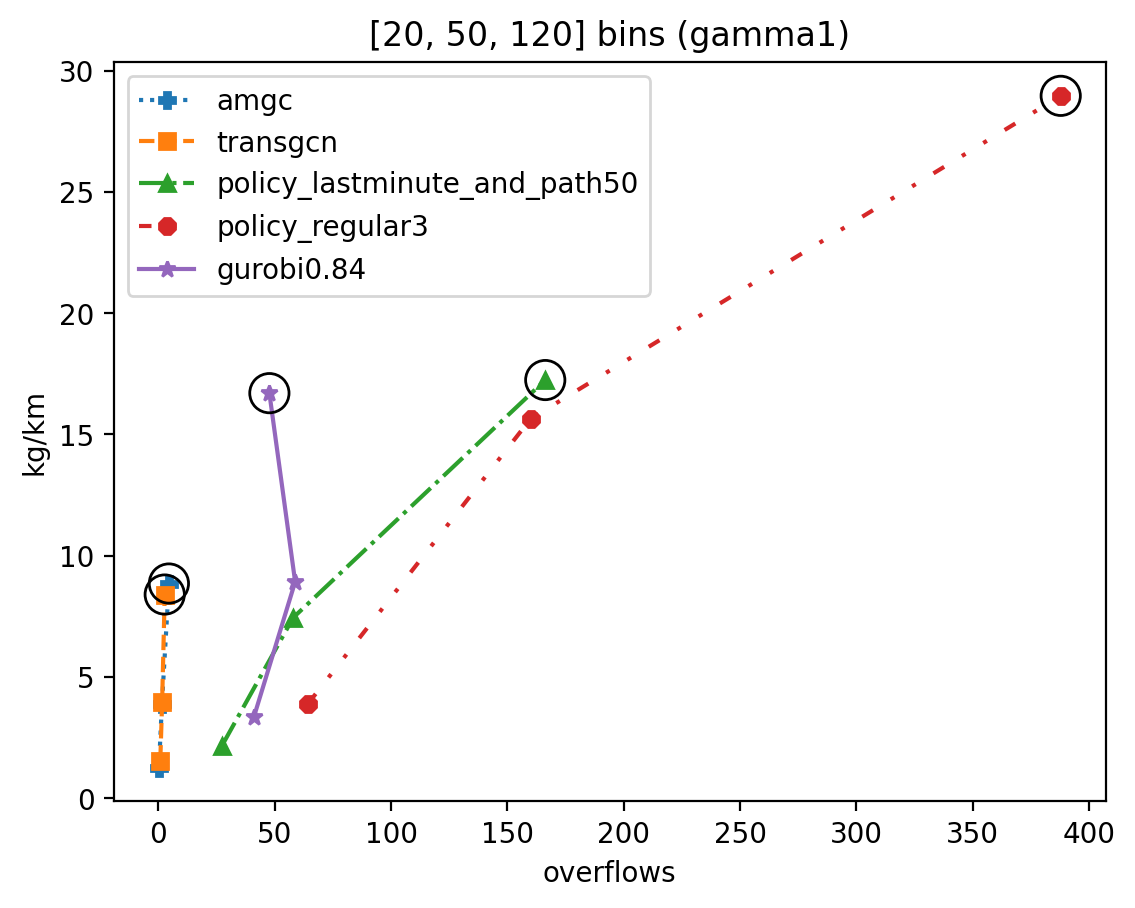

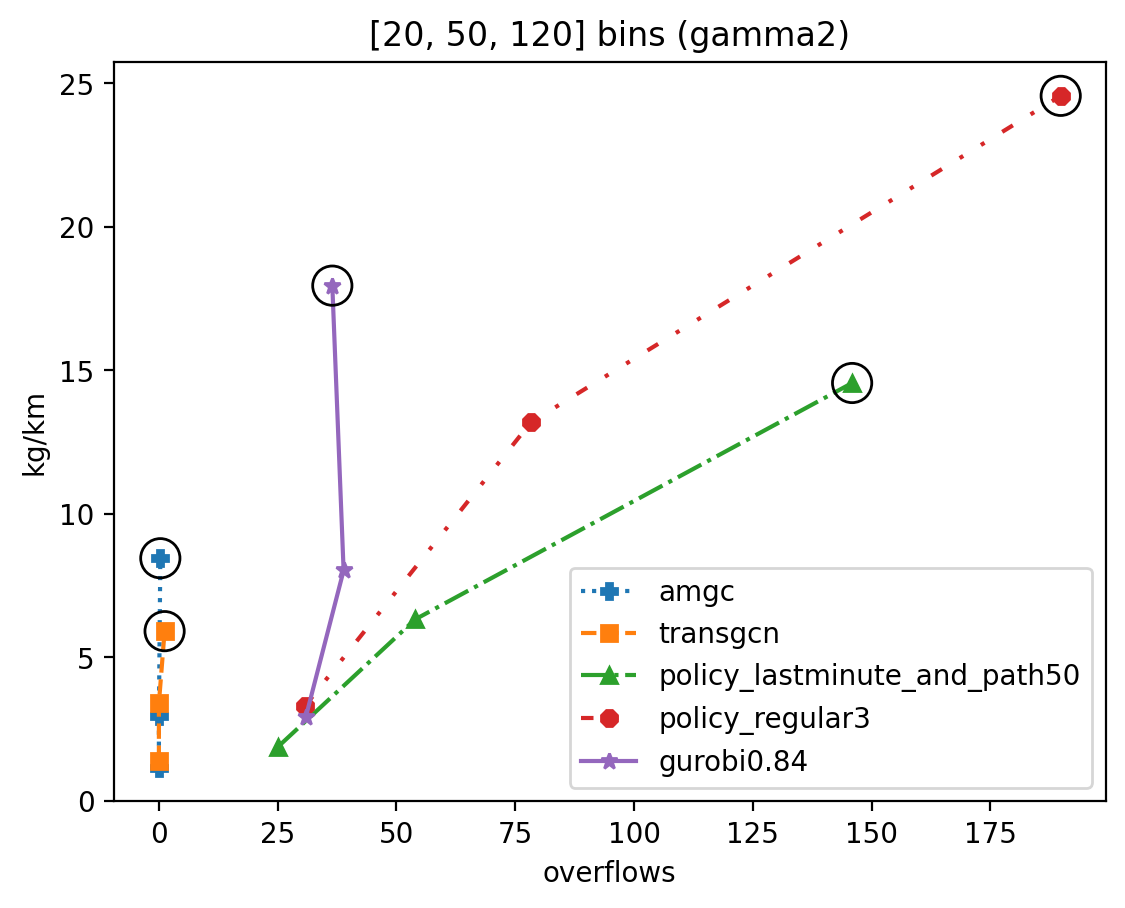

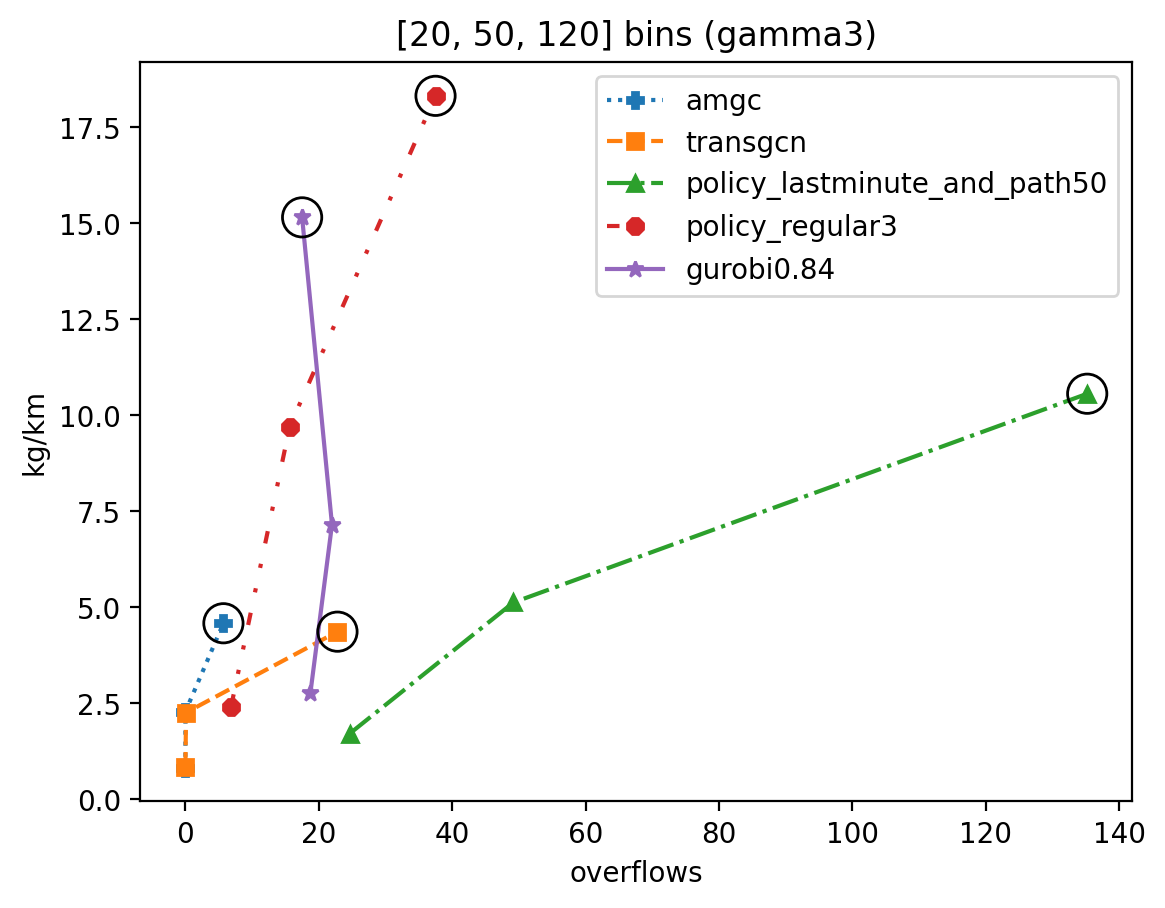

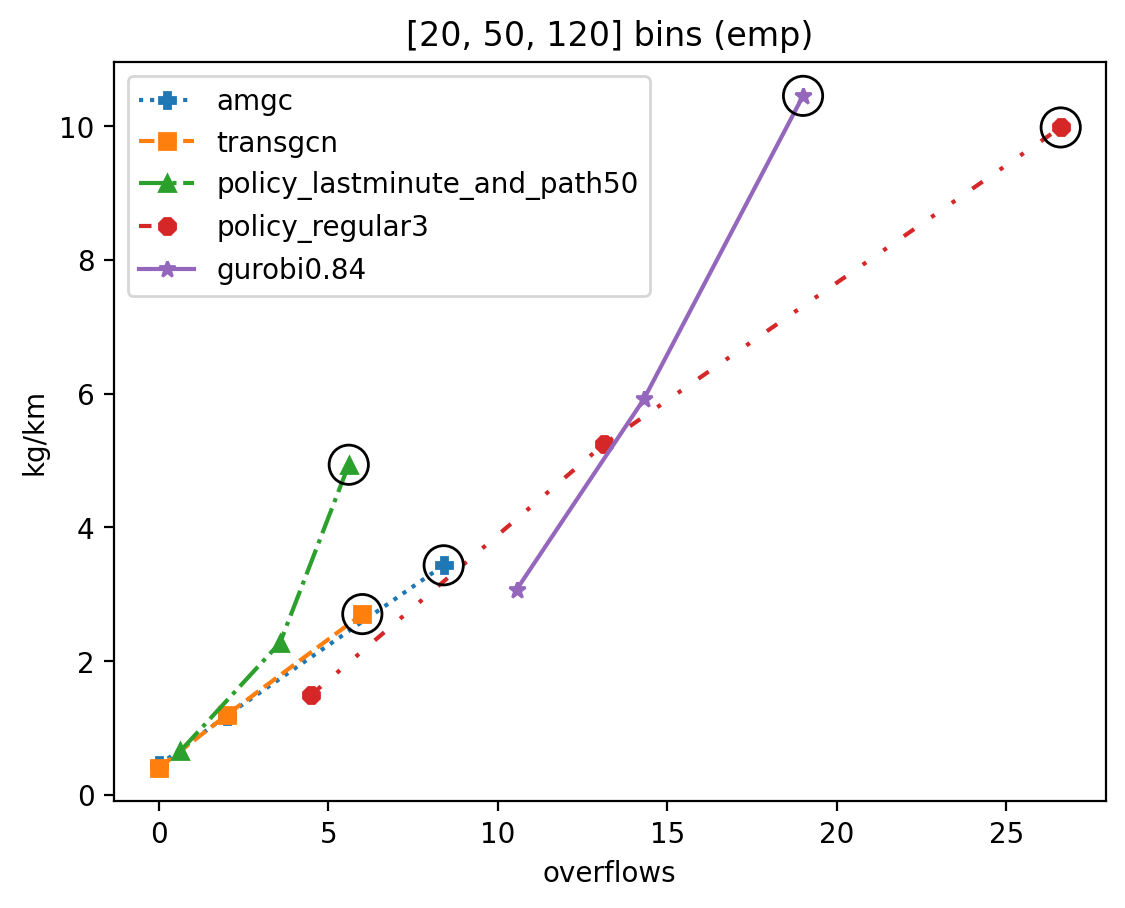

In [ ]:
pds_ls = []
name = "comp"
for disp_dist in display_dists:
    log_display, out_policies = get_results(
        disp_path, N_bins, display_policies, disp_dist
    )
    log_display2 = np.moveaxis(log_display, [0, 1, 2], [0, 2, 1])
    desc_suffix = f"{N_bins} bins ({disp_dist})"
    scale = "linear"
    output_path = (
        os.path.join(output_dir, f"{scale}_{name}{N_bins}_{disp_dist}.png")
        if scale != "linear"
        else os.path.join(output_dir, f"{name}{N_bins}_{disp_dist}.png")
    )

    # Dashed black line na fronteira pareto
    markers = ["P", "s", "^", "8", "*"]
    linestyles = ["dotted", "dashed", "dashdot", (0, (3, 5, 1, 5, 1, 5)), "solid"]
    def plot_func(l1, l2, l3, line, mark):
        return plt.plot(
            [l1[0], l2[0], l3[0]], [l1[6], l2[6], l3[6]], linestyle=line, marker=mark
        )
    pds = plot_linechart(
        output_path,
        log_display2,
        plot_func,
        display_policies,
        "overflows",
        "kg/km",
        desc_suffix,
        fsave=True,
        scale=scale,
        linestyles=linestyles,
        markers=markers,
        annotate=True,
        pareto_front=False,
    )
    pds_ls.append(pds)

In [ ]:
pds_ls = []
for disp_dist in display_dists:
    for metric_id, metric in enumerate(SIM_METRICS):
        if metric == "kg/km":
            metric = "kgperkm"
        log_display, out_policies = get_results(
            disp_path, N_bins, display_policies, disp_dist
        )
        log_display2 = np.moveaxis(log_display, [0, 1, 2], [0, 2, 1])
        desc_suffix = f"{N_bins} bins ({disp_dist})"
        scale = "linear"
        output_path = (
            os.path.join(output_dir, f"{scale}_{metric}{N_bins}_{disp_dist}.png")
            if scale != "linear"
            else os.path.join(output_dir, f"{metric}{N_bins}_{disp_dist}.png")
        )

        # Dashed black line na fronteira pareto
        markers = ["P", "s", "^", "8"]  # , '*']
        linestyles = [
            "dotted",
            "dashed",
            "dashdot",
            (0, (3, 5, 1, 5, 1, 5)),
        ]  # , 'solid']
        def plot_func(x_vals, l1, l2, line, mark):
            return plt.plot(
                    x_vals, [l1[metric_id], l2[metric_id]], linestyle=line, marker=mark
                )
        pds = plot_linechart(
            output_path,
            log_display2,
            plot_func,
            display_policies,
            "number of bins",
            metric,
            f"Comparison {metric}: {desc_suffix}",
            fsave=True,
            x_values=N_bins,
            scale=scale,
            linestyles=linestyles,
            markers=markers,
            annotate=False,
            pareto_front=False,
        )
        pds_ls.append(pds)

In [ ]:
pds_arr = np.array(pds_ls)
sum_tournament = np.sum(pds_arr, axis=(0, 1))
nbins_tournament = np.sum(pds_arr, axis=0)
dists_tournament = np.sum(pds_arr, axis=1)
tournament = np.vstack((nbins_tournament, dists_tournament, sum_tournament))

In [ ]:
df_t1 = pd.DataFrame(display_policies, columns=["policy"])
df_trest = pd.DataFrame(
    tournament.T, columns=["t20", "t50", "tg1", "tg2", "tg3", "te", "tall"]
)
df_tournament = pd.concat([df_t1, df_trest], axis=1)
df_tournament = df_tournament.set_index("policy")
metric_tosort = "tall"
display(sort_dataframe(df_tournament, metric_tosort, ascending_order=False))

Hipoteses:
- Correr um algoritmo de otimização de hyperparâmetros
- Alterar valores do cost function
- Alterar a posição do depot (e normalização)
- Treino supervised antes do reinforcement

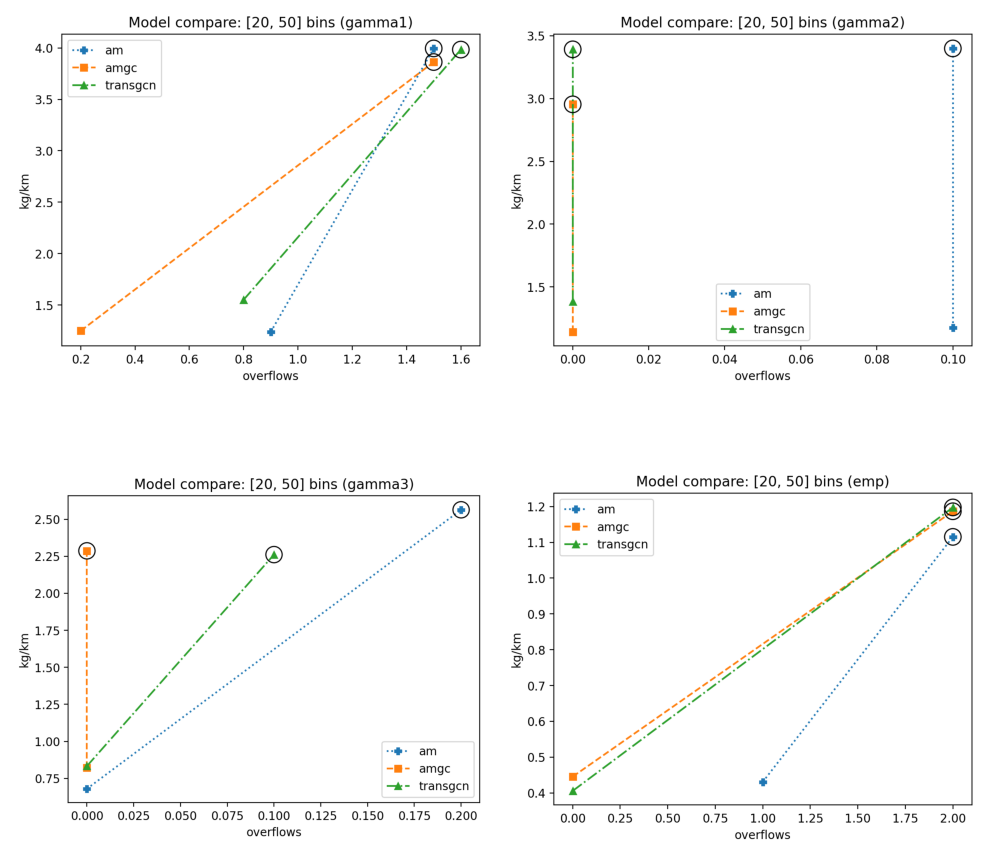

In [4]:
import os

import numpy as np

%matplotlib inline
from PIL import Image

Ndays = 31
N_bins = [20, 50]
proto_path = f"/home/pkhunter/Repositories/wsr_tmp/assets/output/{Ndays}_days/proto"
image_paths = [
    os.path.join(proto_path, img_path)
    for img_path in [
        f"model_compare{N_bins}_gamma1.png",
        f"model_compare{N_bins}_gamma2.png",
        f"model_compare{N_bins}_gamma3.png",
        f"model_compare{N_bins}_emp.png",
    ]
]
images = [np.array(Image.open(img_path).convert("RGB")) for img_path in image_paths]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 2 columns

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.axis("off")

plt.tight_layout()
plt.show()

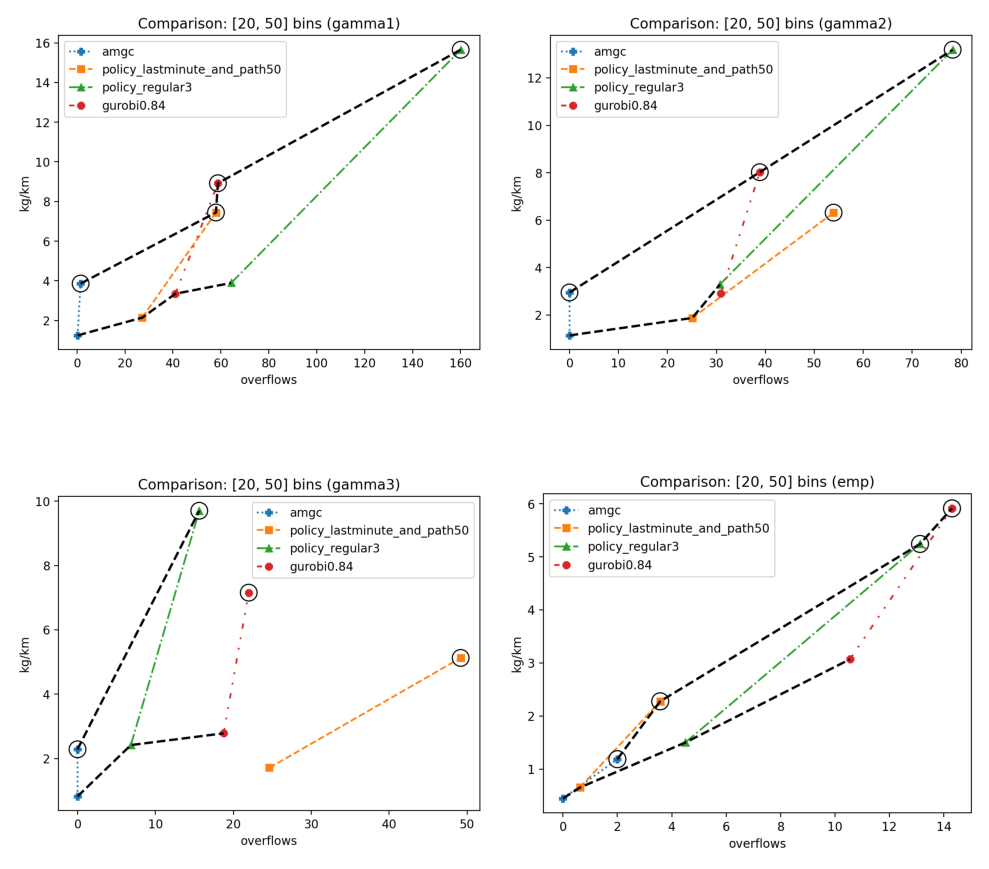

In [5]:
import os

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

Ndays = 31
N_bins = [20, 50]
proto_path = f"/home/pkhunter/Repositories/wsr_tmp/assets/output/{Ndays}_days/proto"
image_paths = [
    os.path.join(proto_path, img_path)
    for img_path in [
        f"comp{N_bins}_gamma1.png",
        f"comp{N_bins}_gamma2.png",
        f"comp{N_bins}_gamma3.png",
        f"comp{N_bins}_emp.png",
    ]
]
images = [np.array(Image.open(img_path).convert("RGB")) for img_path in image_paths]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 2 columns

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.axis("off")

plt.tight_layout()
plt.show()

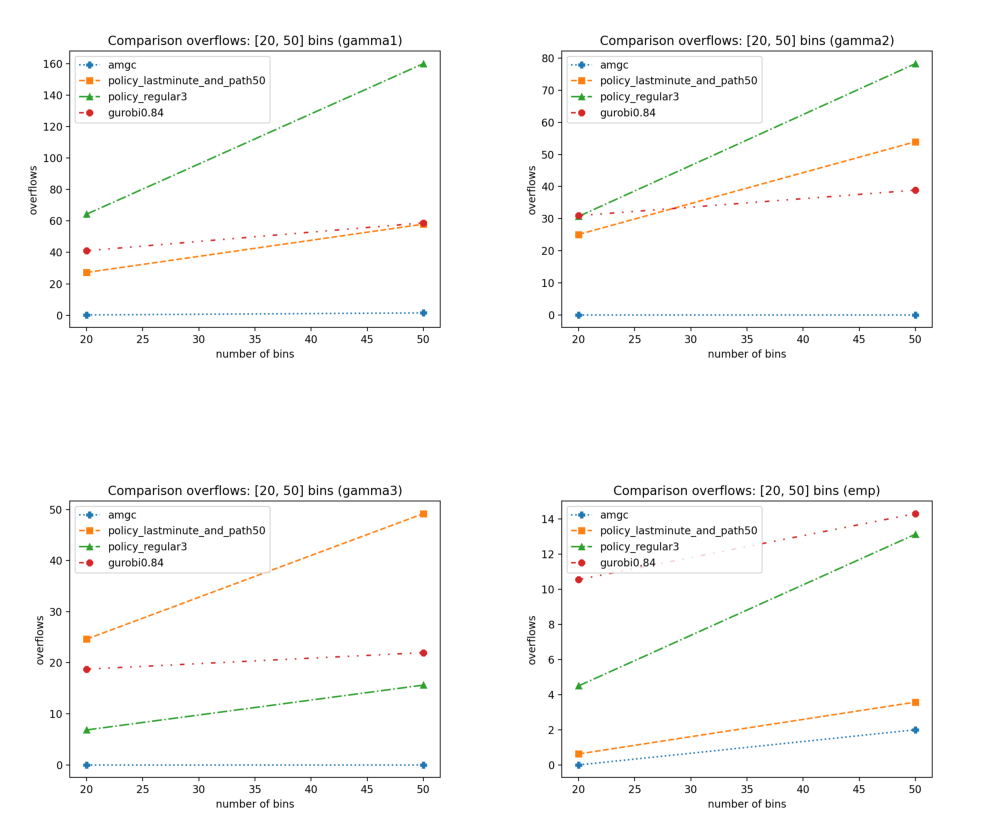

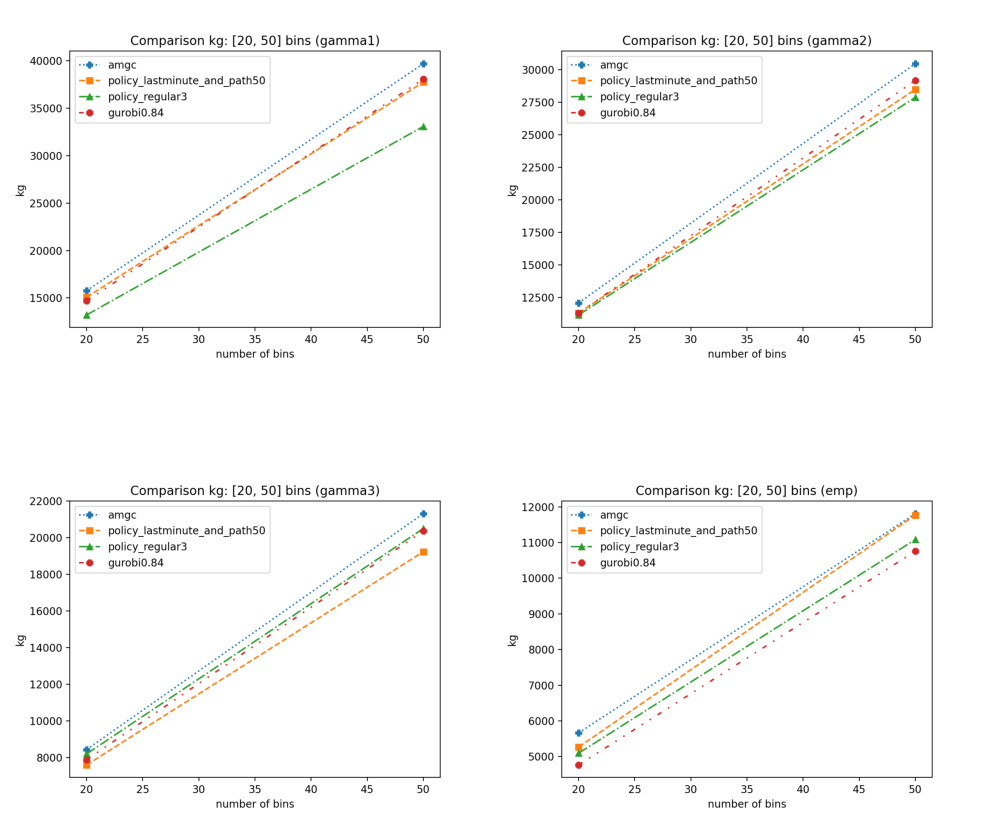

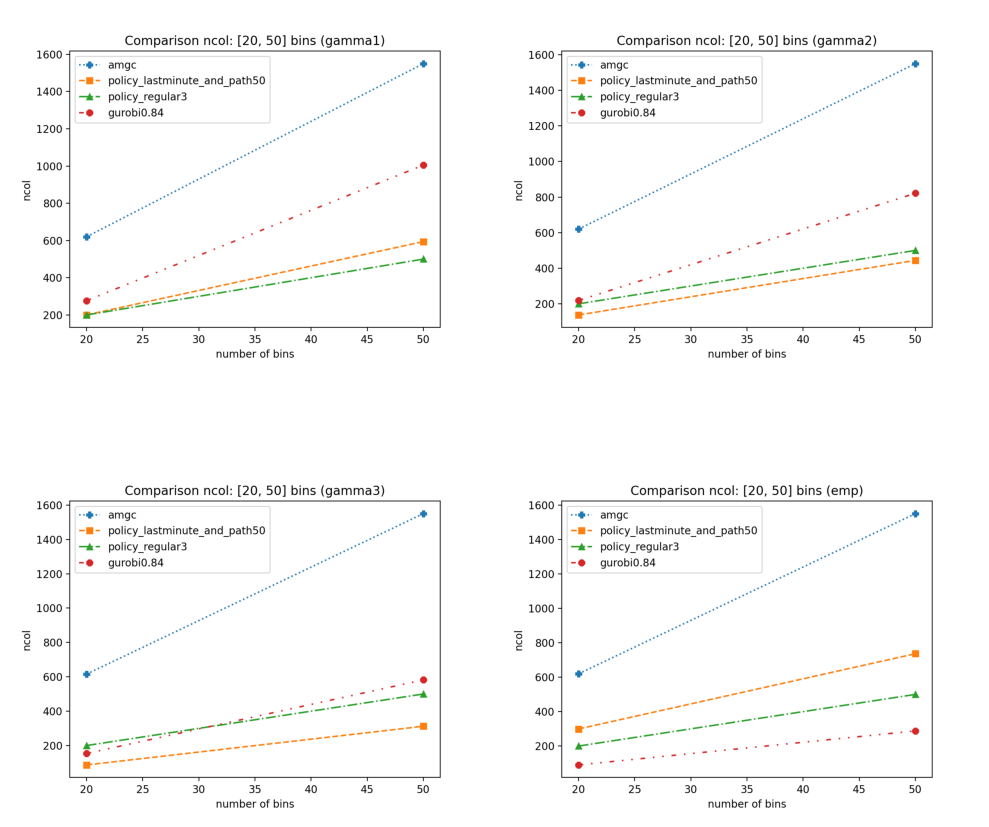

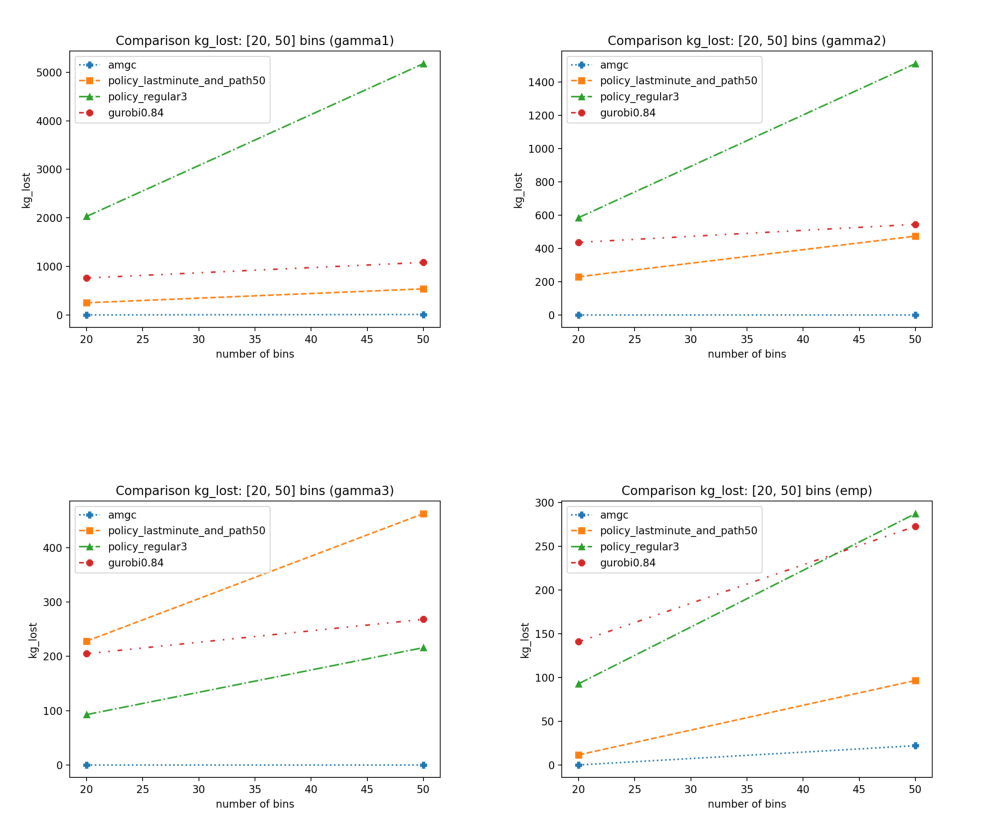

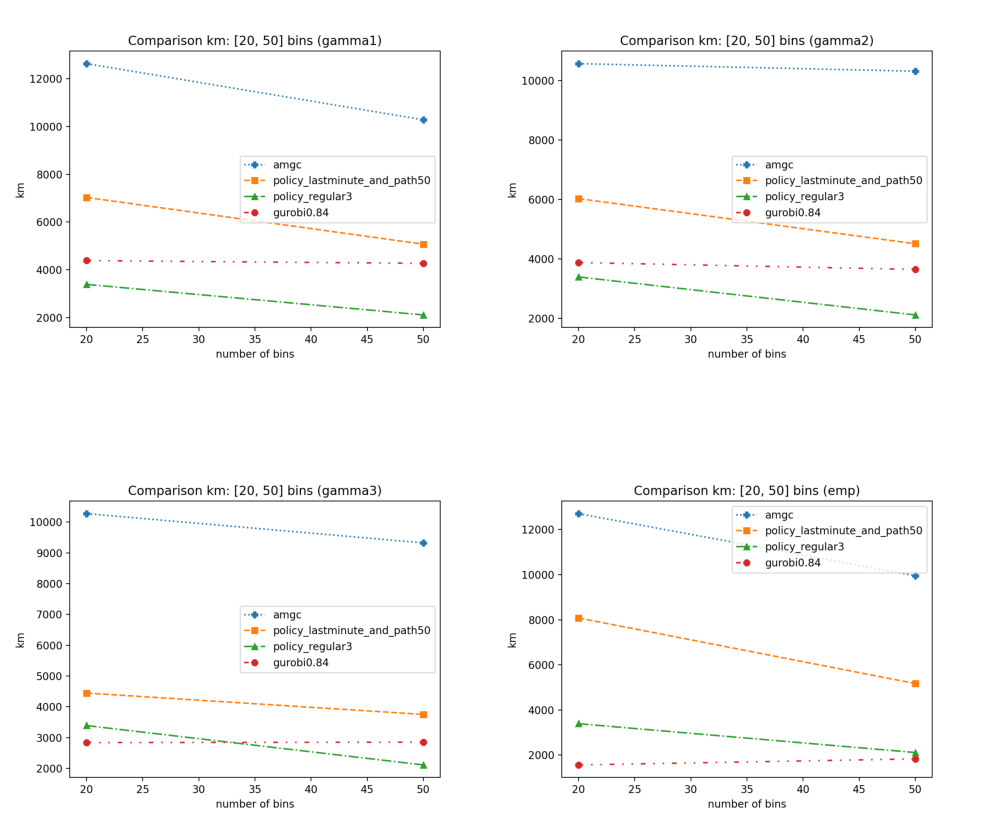

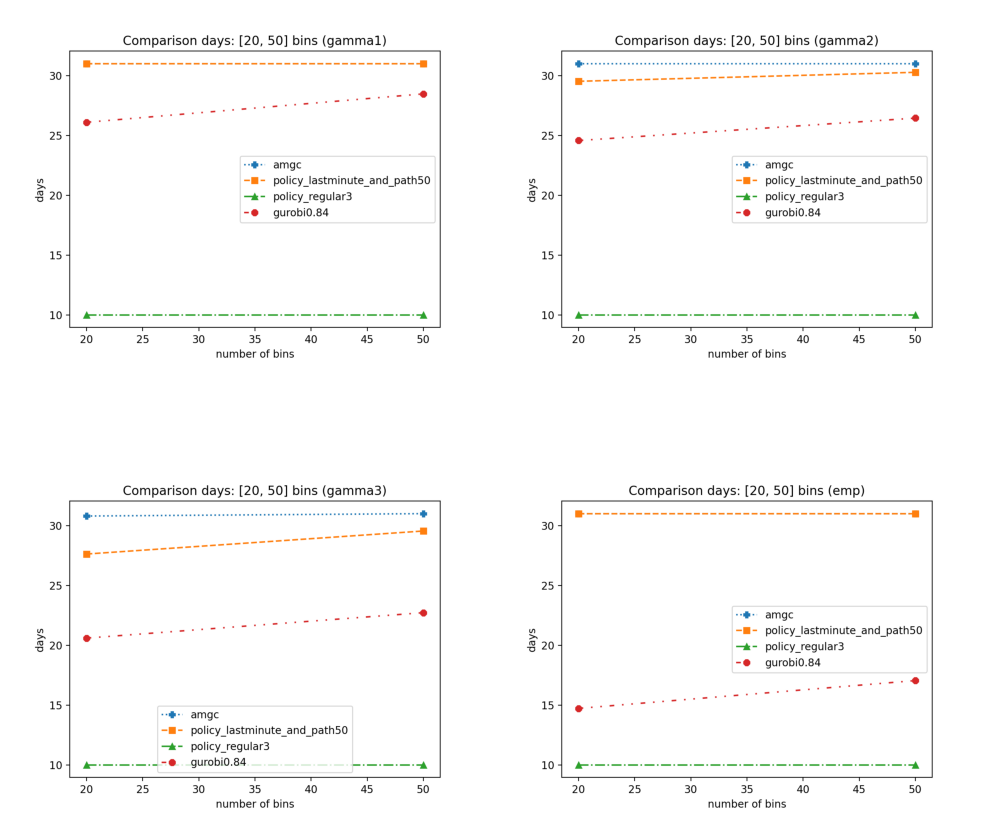

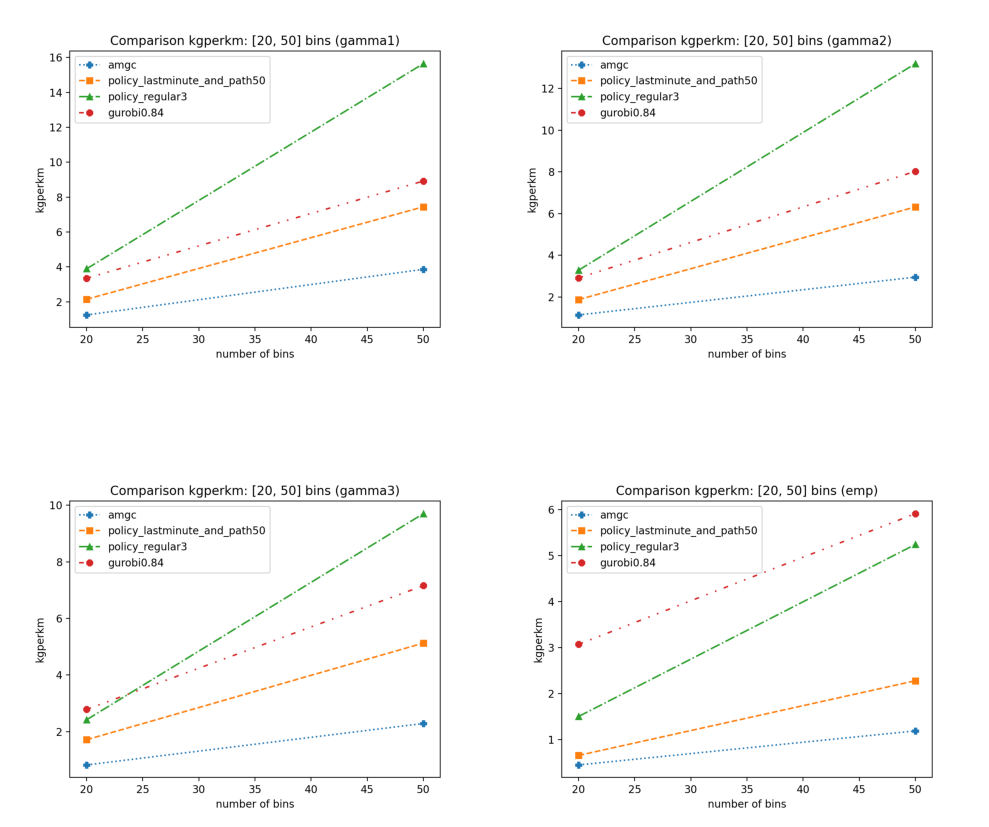

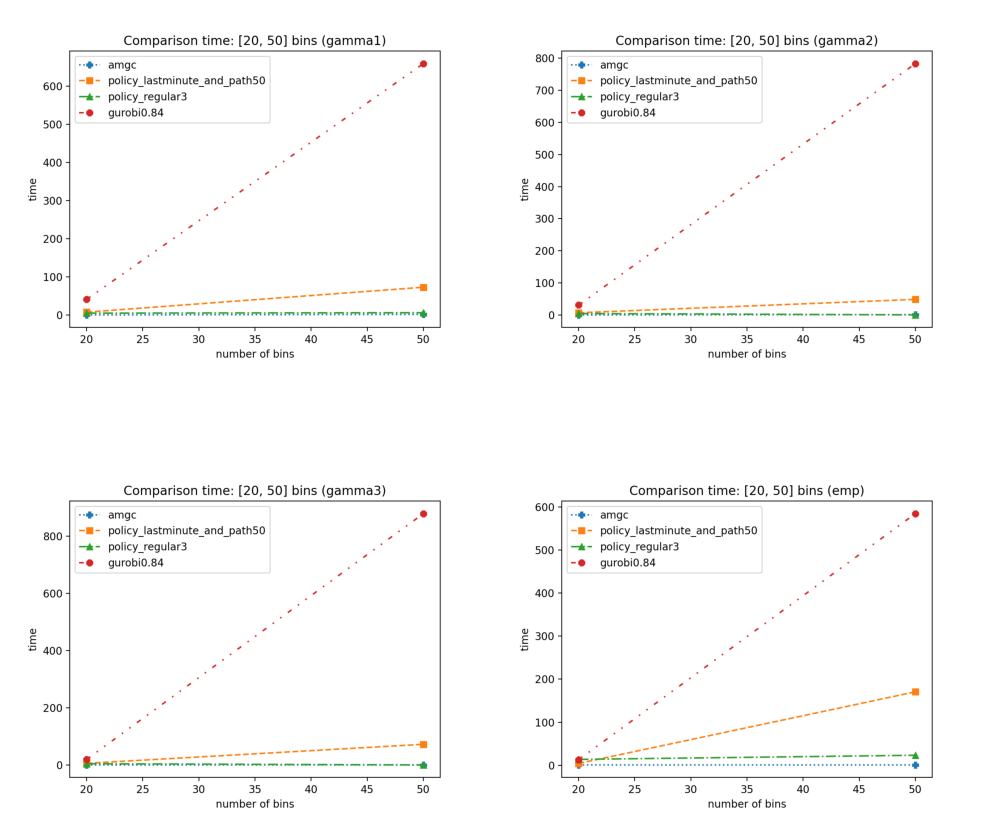

In [ ]:
import os

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

Ndays = 31
N_bins = [20, 50]
proto_path = f"/home/pkhunter/Repositories/wsr_tmp/assets/output/{Ndays}_days/proto"
for metric_id, metric in enumerate(SIM_METRICS):
    if metric == "kg/km":
        metric = "kgperkm"
    image_paths = [
        os.path.join(proto_path, img_path)
        for img_path in [
            f"{metric}{N_bins}_gamma1.png",
            f"{metric}{N_bins}_gamma2.png",
            f"{metric}{N_bins}_gamma3.png",
            f"{metric}{N_bins}_emp.png",
        ]
    ]
    images = [np.array(Image.open(img_path).convert("RGB")) for img_path in image_paths]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 2 columns

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()